In [3]:
import torch

q = torch.distributions.Normal(2, 4)

z = q.rsample()
print(z)

tensor(-3.6433)


## KL divergence intuition
Here we show the intuition of minimizing the KL

In [2]:
p = torch.distributions.Normal(0, 1)
q = torch.distributions.Normal(2, 4)

log_pz = p.log_prob(z)
log_qzx = q.log_prob(z)

print('log prob pz: ', log_pz, 'prob:', torch.exp(log_pz))
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob pz:  tensor(-7.4875) prob: tensor(0.0006)
log prob qzx:  tensor(-2.3877) prob: tensor(0.0918)


In [3]:
kl_divergence = log_qzx - log_pz
kl_divergence

tensor(5.0998)

now, if we manually move q closer to p, we see that this distrance has shrunk. 

In [4]:
# old q = torch.distributions.Normal(2, 4)
q = torch.distributions.Normal(1, 2)

log_qzx = q.log_prob(z)
print('log prob qzx: ', log_qzx, 'prob:', torch.exp(log_qzx))

log prob qzx:  tensor(-2.4731) prob: tensor(0.0843)


new kl

In [5]:
new_kl_divergence = log_qzx - log_pz
new_kl_divergence

tensor(5.0144)

### VAE Implementation

In [1]:
%%capture
! pip install pytorch-lightning
! pip install lightning-bolts

In [2]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (resnet18_decoder,resnet18_encoder)


In [4]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [5]:
from pl_bolts.datamodules import CIFAR10DataModule

cifar10 = CIFAR10DataModule('.')

Now we train!

In [6]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=30, progress_bar_refresh_rate=10)
trainer.fit(vae, cifar10)

Global seed set to 1234
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:116: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:115: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:134: LightningDeprecationWarning: DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7.
  "DataModule property `val_transforms` was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total e

Training: 0it [00:00, ?it/s]

In [11]:
mu = torch.zeros((1,256))
std = torch.zeros((1,256))

## Plot an image

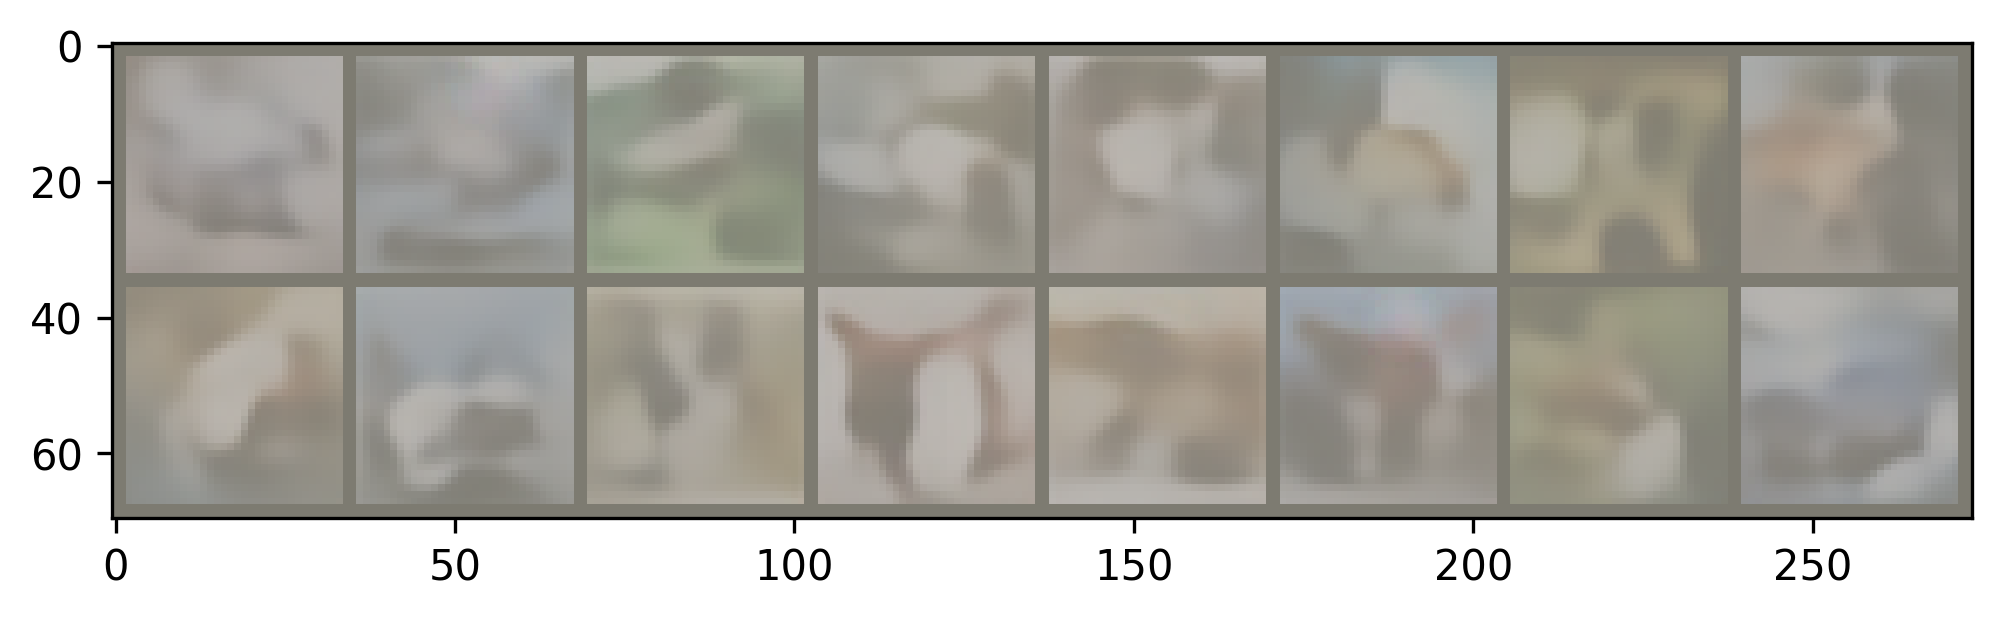

In [12]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);